In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import tensorflow as tf


from IPython.display import clear_output
from time import sleep
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow import keras as keras

from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import  ReLU, Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D, ZeroPadding2D
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

%matplotlib inline
%load_ext tensorboard

print("tensorflow version : ${}".format(tf.__version__))

tensorflow version : $1.15.0


Using TensorFlow backend.


In [2]:
# Use GPU if anabled
# 
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4277805956230890601
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12487486706928879850
physical_device_desc: "device: XLA_CPU device"
]


[]

In [3]:
filename_training = './training.csv'
filename_test = './test.csv'
filename_lookup = './IdLookupTable.csv'
filename_samplesubmission = './SampleSubmission.csv'

IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96

FEATURES_COUNT = 31

ROWS_COUNT_TRAINING = 7049
ROWS_COUNT_TRAINING_VALID = 2140
ROWS_COUNT_TEST = 1783

In [4]:
def load_file(filename=None, cols=None):
    if filename is None:
        print("ERROR: No file")
        return
    df = pd.read_csv(filename)
    df['Image'] = df['Image'].apply(lambda row: np.fromstring(row, dtype=int, sep=' '))
    print(df.info()) 
#     @TODO: test it with different fill it time left...
#     df.fillna(method = 'ffill', inplace = True)
    df = df.dropna()
    print(df.info()) 
    return df

In [5]:
input_training = load_file(filename_training)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [6]:
def show_images_grid(df, image_from_index=0):
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(
        left = 0, 
        right = 1, 
        bottom = 0, 
        top = 1, 
        hspace = 0.05, 
        wspace = 0.05
    )
    plt_images_count = 16
    for index in range(0, plt_images_count):
        ax = fig.add_subplot(4, 4, index + 1, xticks=[], yticks=[])
#         curr_index = np.random.randint(2140)
        curr_index = image_from_index + index
        if curr_index in df.index:
            image_raw = df['Image'][curr_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT))
            image = plt.imshow(image_raw, cmap='gray')
            for i in range(1, FEATURES_COUNT, 2):
                image_dots_x = df.loc[index][i-1]
                image_dots_y = df.loc[index][i]
                plt.plot(image_dots_x, image_dots_y, 'ob')

    plt.show()

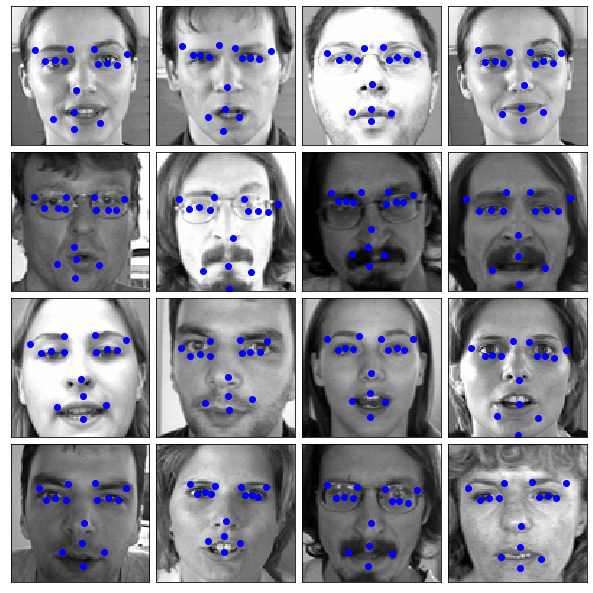

In [7]:
show_images_grid(input_training, image_from_index=20)

In [8]:
X_training = np.asarray([input_training['Image']], dtype = np.uint8).reshape(input_training.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)
y_training = input_training.drop(['Image'], axis = 1)
y_training = y_training.to_numpy()
print(X_training.shape)
print(y_training.shape)

(2140, 96, 96, 1)
(2140, 30)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size = 0.3)
print("X_train")
print(X_train.shape)
print(X_train.shape)
print("X_test")
print(X_test.shape)
print(X_test.shape)
print("y_train")
print(y_train.shape)
print(y_train.shape)
print("y_test")
print(y_test.shape)
print(y_test.shape)

X_train
(1498, 96, 96, 1)
(1498, 96, 96, 1)
X_test
(642, 96, 96, 1)
(642, 96, 96, 1)
y_train
(1498, 30)
(1498, 30)
y_test
(642, 30)
(642, 30)


In [10]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
______________________________________

In [11]:
model.compile(optimizer='Adam', 
              loss='mse', 
              metrics=['mae'])

In [12]:
hist = model.fit(X_train, y_train, epochs=2)


Epoch 1/2
1498/1498 [==============================] - 24s 16ms/step - loss: 273.2623 - mae: 11.6803
Epoch 2/2
1498/1498 [==============================] - 22s 15ms/step - loss: 68.3466 - mae: 6.5130


In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 162.69665667572497
Test accuracy: 10.740619659423828


In [14]:
model.save('miw_2020.h5')

In [15]:
input_test = load_file(filename_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 41.8+ KB
None


In [16]:
X_test = np.asarray([input_test['Image']], dtype = np.uint8).reshape(input_test.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)
y_test_predict = model.predict(X_test)
y_training_predict = model.predict(X_training)

print(y_test_predict)
print(y_training_predict)



[[47.703106 24.337748 20.752571 ... 46.415836 33.738304 48.715977]
 [48.346355 24.83701  20.527536 ... 51.709732 32.811543 59.18488 ]
 [55.32958  30.598469 31.696173 ... 59.845703 42.908295 65.715645]
 ...
 [51.59747  26.969774 24.370512 ... 56.625977 37.55284  57.690655]
 [51.19283  27.039125 25.358976 ... 53.941402 37.279213 58.533253]
 [43.899426 23.868395 19.148228 ... 48.124706 27.879688 53.152576]]
[[55.32502  30.715721 25.326632 ... 57.669067 38.449917 67.42095 ]
 [51.83411  30.839447 32.438877 ... 58.968704 41.558308 61.175724]
 [51.00776  24.286667 26.674196 ... 50.337814 35.803474 53.85284 ]
 ...
 [51.152214 30.690163 26.17914  ... 60.291176 38.60068  63.38973 ]
 [64.84918  31.543621 25.32335  ... 73.3997   55.406277 67.75098 ]
 [52.03164  25.15304  21.424955 ... 53.39009  39.297203 61.34415 ]]


In [23]:
def show_predict_images_grid(df, y_init, y_predict, image_from_index=0):
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(
        left = 0, 
        right = 1, 
        bottom = 0, 
        top = 1, 
        hspace = 0.05, 
        wspace = 0.05
    )
    plt_images_count = 16
    for index in range(0, plt_images_count):
        ax = fig.add_subplot(4, 4, index + 1, xticks=[], yticks=[])
        curr_index = np.random.randint(2140)
#         curr_index = image_from_index + index
        image_raw = df[curr_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT))
        image = plt.imshow(image_raw, cmap='gray')
        for i in range(1, FEATURES_COUNT, 2):
            image_dots_x1 = y_init[index][i - 1]
            image_dots_y1 = y_init[index][i]
            plt.plot(image_dots_x1, image_dots_y1, 'ob')
            image_dots_x2 = y_predict[index][i - 1]
            image_dots_y2 = y_predict[index][i]
            plt.plot(image_dots_x2, image_dots_y2, 'x', color='r')

    plt.show()

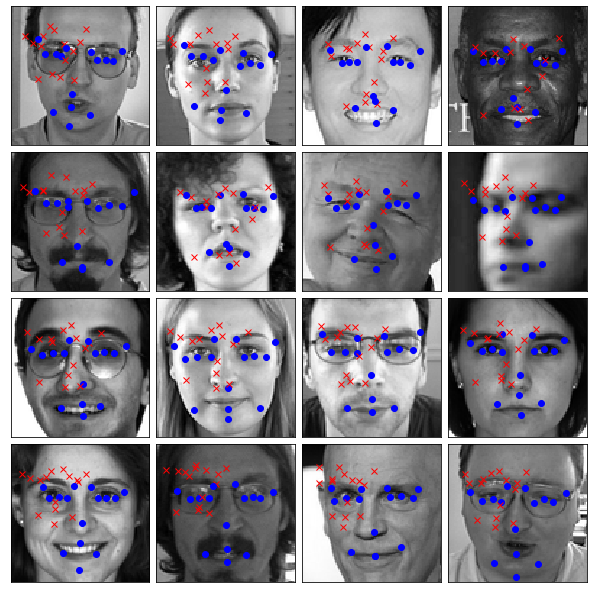

In [26]:
show_predict_images_grid(X_training, y_test, y_test_predict, 10)

In [28]:
input_lookup = pd.read_csv(filename_lookup)
header = list(input_training.drop(['Image'], axis = 1).columns)
test_predicts = pd.DataFrame(y_test_predict, columns = header)



for i in range(input_lookup.shape[0]):
    image_index = input_lookup.ImageId[i] - 1
    feature_index = input_lookup.FeatureName[i]
    input_lookup.Location[i] = test_predicts.loc[image_index][feature_index]

/home/robson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
input_samplesubmission = pd.read_csv(filename_samplesubmission)
input_samplesubmission.Location = input_lookup.Location
miw_submission = input_samplesubmission
miw_submission.to_csv('miw_submission.csv', index = False)
print(miw_submission)

       RowId   Location
0          1  47.703106
1          2  24.337748
2          3  20.752571
3          4  27.120546
4          5  36.551056
...      ...        ...
27119  27120  23.362553
27120  27121  30.733837
27121  27122  37.394005
27122  27123  27.879688
27123  27124  53.152576

[27124 rows x 2 columns]
